Based on: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
attempt 2 COMPLETE OVER haul

Overhauling to use csv instead of dataset in the hopes I can fix the limitation to 1 neuron problem

In [1]:
#Data Visualization
import pandas as pd

#load data
resume = pd.read_csv("/content/UpdatedResumeDataSet.csv")

#view all of the categories
len(resume.iloc[:, 0].unique())
#25 categories
resume.iloc[:, 0].unique()
#note that all of the categories are good, there doesnt need for there to be any
#more data marshalling for the categories
#this is why I choose this data set


array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [2]:
#view head
resume.head()
#note all the crappy characters in the resume to be cleaned

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [3]:
#data clean up
#remove special characters with regular expressions
#https://stackoverflow.com/questions/43358857/how-to-remove-special-characters-except-space-from-a-file-in-python
#https://stackoverflow.com/questions/25292838/applying-regex-to-a-pandas-dataframe
import re

#removes special chars
def clean_chars(clean):
    return re.sub(r"[^a-zA-Z0-9]+", ' ', clean)

# test = "Details \r\nMay 2013 to May 2017 B."
# final = [re.sub(r"[^a-zA-Z0-9]+", ' ', test)]
# print(final)
#['Details May 2013 to May 2017 B ']

#need to strip trailing white spaces
resume.Resume = resume.Resume.apply(lambda x: clean_chars(x).strip())
resume.Resume

0      Skills Programming Languages Python pandas num...
1      Education Details May 2013 to May 2017 B E UIT...
2      Areas of Interest Deep Learning Control System...
3      Skills R Python SAP HANA Tableau SAP HANA SQL ...
4      Education Details MCA YMCAUST Faridabad Haryan...
                             ...                        
957    Computer Skills Proficient in MS office Word B...
958    Willingness to accept the challenges Positive ...
959    PERSONAL SKILLS Quick learner Eagerness to lea...
960    COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...
961    Skill Set OS Windows XP 7 8 8 1 10 Database MY...
Name: Resume, Length: 962, dtype: object

In [4]:
resume.head()

,Category,Resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


In [5]:
#data restrict length to 512 characters
import itertools

#https://stackoverflow.com/questions/22767509/python-get-the-x-first-words-in-a-string
# test = 'Computer Skills Proficient in MS office Word B'
# test = test.split(' ')
# test = test[:5]
# test
# #['Computer', 'Skills', 'Proficient', 'in', 'MS']
# test = ' '.join(test)
# test


resume.Resume = resume.Resume.apply(lambda x: ' '.join(x.split(' ')[:512]))
resume.Resume

0      Skills Programming Languages Python pandas num...
1      Education Details May 2013 to May 2017 B E UIT...
2      Areas of Interest Deep Learning Control System...
3      Skills R Python SAP HANA Tableau SAP HANA SQL ...
4      Education Details MCA YMCAUST Faridabad Haryan...
                             ...                        
957    Computer Skills Proficient in MS office Word B...
958    Willingness to accept the challenges Positive ...
959    PERSONAL SKILLS Quick learner Eagerness to lea...
960    COMPUTER SKILLS SOFTWARE KNOWLEDGE MS Power Po...
961    Skill Set OS Windows XP 7 8 8 1 10 Database MY...
Name: Resume, Length: 962, dtype: object

In [6]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 498.0 MB 14 kB/s 
     |████████████████████████████████| 5.8 MB 74.7 MB/s 
     |████████████████████████████████| 1.4 MB 82.6 MB/s 
     |████████████████████████████████| 462 kB 92.0 MB/s 


In [7]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.7 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 352 kB 80.3 MB/s 
     |████████████████████████████████| 238 kB 84.2 MB/s 
     |████████████████████████████████| 1.3 MB 69.5 MB/s 
     |████████████████████████████████| 118 kB 91.6 MB/s 


In [8]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [9]:
#make test set with sk learn
df = resume
possible_labels = df.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Data Science': 0,
 'HR': 1,
 'Advocate': 2,
 'Arts': 3,
 'Web Designing': 4,
 'Mechanical Engineer': 5,
 'Sales': 6,
 'Health and fitness': 7,
 'Civil Engineer': 8,
 'Java Developer': 9,
 'Business Analyst': 10,
 'SAP Developer': 11,
 'Automation Testing': 12,
 'Electrical Engineering': 13,
 'Operations Manager': 14,
 'Python Developer': 15,
 'DevOps Engineer': 16,
 'Network Security Engineer': 17,
 'PMO': 18,
 'Database': 19,
 'Hadoop': 20,
 'ETL Developer': 21,
 'DotNet Developer': 22,
 'Blockchain': 23,
 'Testing': 24}

In [10]:
df['label'] = df.Category.replace(label_dict)


In [11]:
df.head()


,Category,Resume,label
0,Data Science,Skills Programming Languages Python pandas num...,0
1,Data Science,Education Details May 2013 to May 2017 B E UIT...,0
2,Data Science,Areas of Interest Deep Learning Control System...,0
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...,0
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...,0


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.7, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [13]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['Category', 'label', 'Resume']).count()

data_type
Category      label Resume                                                       
Advocate      2     Education Details B Com LL B University of Clac...          2
                    Education Details LLB Dibrugarh University Advo...          2
                    Education Details November 2016 to January 2019...          2
                    Good grasping quality and skillful work Educati...          2
                    Hard working Quick learnerEducation Details Jun...          2
...                                                                           ...
Testing       24    Willingness to accept the challenges Positive t...         10
Web Designing 4     Education Details B C A Bachelor Computer Appli...          9
                    Education Details January 2016 B Sc Information...          9
                    IT SKILLS Languages C Basic JAVA Basic Web Tech...          9
                    Technical Skills Web Technologies Angular JS HT...         18

[166 rows x 1 columns]

In [14]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [15]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [16]:
text_test = ['python ai engineer 12 years']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 18750  9932  3992  2260  2086   102     0     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(25, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)



In [19]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.5144483  0.5021654  0.504103   0.50805867 0.5011499  0.5040763
  0.5069056  0.50157046 0.5073777  0.54418504 0.502838   0.5024589
  0.50382304 0.5266054  0.50958663 0.5028729  0.51390105 0.50272644
  0.5033538  0.5354874  0.5336166  0.5022576  0.50197935 0.5091496
  0.5050396 ]], shape=(1, 25), dtype=float32)


In [20]:
# loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
# metrics = tf.metrics.BinaryAccuracy()

loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    name='categorical_crossentropy'
)

metrics = tf.metrics.CategoricalAccuracy()

In [25]:
epochs = 5
# steps_per_epoch = len(df)
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')

In [ ]:
#X_train, X_val, y_train, y_val 

In [26]:
classifier_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-5),
                         loss=loss,
                         metrics=metrics)
# classifier_model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
len(X_train)

288

In [29]:
X_train

array([468, 808, 317, 776, 200, 902, 602, 723, 386, 397, 217, 153, 177,
       823, 816, 556, 955, 685,  62, 958, 558, 719,  50, 749, 354, 822,
       409, 237,  12, 690, 858, 519, 613, 333, 680, 439, 374, 229,  89,
       946,  72, 332, 491, 155, 418, 184, 197,  60, 170, 323, 710, 939,
       107, 405,  77,   4,  25, 325, 277, 772,  75, 532, 622, 597, 428,
       278, 142, 315, 528, 923, 266, 639, 274, 175, 226, 535, 644, 193,
       179, 910,  44, 338, 655, 841, 327, 113, 569, 618,  87, 157, 722,
       897, 307, 375, 794, 514, 584, 442, 832, 646, 848, 564, 289, 653,
       702, 765, 770,  24, 363, 147, 834, 868, 638, 878, 907, 753, 516,
       474, 620, 839, 888,  88, 163, 881, 813, 941, 406, 399, 731, 761,
       659, 198, 688, 715, 727, 360, 830, 509, 883, 486, 239, 626, 647,
       806, 192, 282, 670, 588, 718, 132, 390,  66, 583, 436, 195, 792,
       751, 541, 593, 164, 489, 508, 741, 864,  80, 389, 594, 423, 114,
       636, 378, 135, 628, 657, 495, 708, 130, 292, 441, 686, 52

In [30]:
y_train

array([12, 21,  8, 20,  5, 24, 16, 19,  9,  9,  5,  4,  4, 21, 21, 15, 24,
       18,  1, 24, 15, 19,  1, 20,  9, 21, 10,  6,  0, 18, 23, 14, 16,  9,
       18, 11,  9,  6,  2, 24,  1,  9, 13,  4, 10,  4,  5,  1,  4,  9, 19,
       24,  3, 10,  1,  0,  0,  9,  7, 20,  1, 14, 16, 15, 10,  7,  4,  8,
       14, 24,  7, 16,  7,  4,  6, 14, 16,  5,  4, 24,  1,  9, 17, 22,  9,
        3, 15, 16,  2,  4, 19, 24,  8,  9, 21, 14, 15, 11, 22, 16, 22, 15,
        7, 16, 18, 20, 20,  0,  9,  4, 22, 23, 16, 23, 24, 20, 14, 12, 16,
       22, 23,  2,  4, 23, 21, 24, 10,  9, 19, 20, 17,  5, 18, 19, 19,  9,
       22, 13, 23, 13,  6, 16, 16, 21,  5,  7, 17, 15, 19,  3,  9,  1, 15,
       11,  5, 21, 20, 14, 15,  4, 13, 13, 19, 23,  1,  9, 15, 10,  3, 16,
        9,  3, 16, 17, 13, 18,  3,  7, 11, 18, 14, 18, 10,  7, 21, 14, 17,
        2, 17,  1,  9,  0,  6,  8, 24,  5, 24, 22, 24, 22,  3,  6, 14, 24,
       24,  9,  9,  6, 21, 16, 23,  6,  4, 24, 23, 14, 24, 24, 12, 23,  0,
        1,  6,  9,  5,  5

In [31]:
history = classifier_model.train_on_batch(X_train,y_train)
    
#     train_on_batch(
#     x,
#     y=None,
#     sample_weight=None,
#     class_weight=None,
#     reset_metrics=True,
#     return_dict=False
# )

#not sure why this is. The model runs just fine. I am expecting 25 outputs (1 per neuron) this is because there are 25 classes.
#train on batch seems to think there is only 1 neuron as its expecting shape 288 (samples), 1 (1 output) instead of 288, 25

ValueError: ignored

In [28]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(X_train,y_train,
                               validation_data = (X_val, y_val),
                               epochs=epochs)



Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1
Epoch 1/5


ValueError: ignored

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

61/61 [==============================] - 38s 621ms/step - loss: -310.4288 - binary_accuracy: 0.0374
Loss: -310.4288330078125
Accuracy: 0.03742203861474991


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


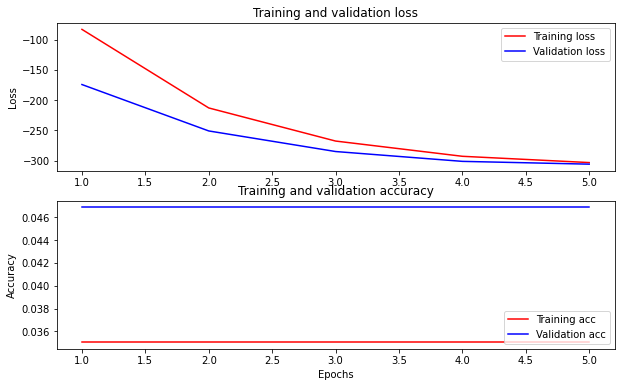

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'I am an ai python developer',  # this is the same sentence tried earlier
    'I test applications',
    'I love bitcoin to the moon block',
    'I deploy computers',
    'I have great people skills'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: I am an ai python developer    : score: 0.731059
input: I test applications            : score: 0.731059
input: I love bitcoin to the moon block : score: 0.731059
input: I deploy computers             : score: 0.731059
input: I have great people skills     : score: 0.731059

Results from the model in memory:
input: I am an ai python developer    : score: 0.731059
input: I test applications            : score: 0.731059
input: I love bitcoin to the moon block : score: 0.731059
input: I deploy computers             : score: 0.731059
input: I have great people skills     : score: 0.731059



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: I am an ai python developer    : score: 0.731059
input: I test applications            : score: 0.731059
input: I love bitcoin to the moon block : score: 0.731059
input: I deploy computers             : score: 0.731059
input: I have great people skills     : score: 0.731059

